In [1]:
# notebook to obtain results for Figures 2, 3, and 4 of https://arxiv.org/pdf/2508.05390

In [2]:
import numpy as np
import scipy
import pandas

from inquanto.core._io import save_pickle, load_pickle

from inquanto.ansatzes import (
    MultiConfigurationState, 
    MultiConfigurationStateSparse, 
    MultiConfigurationAnsatz,
    MultiConfigurationAnsatzSparse,
)
from inquanto.states import QubitState, QubitStateString
from inquanto.operators import FermionOperator, QubitOperator
from inquanto.computables import ExpectationValue

from inquanto.express import run_vqe

from pytket.extensions.qiskit import AerStateBackend
from pytket.circuit import OpType

In [3]:
def c2h4_geom(theta_deg):
    """ 
    This function returns the geometry for C2H4. 
    This function is not used in this notebook, but is shown here in case the user would like to regenerate classical chemistry data. 
    
    
    The function c2h4_geom(theta_deg) is called for each C2H4 torsion angle (in degrees) in angles_list
    angles_list = [0, 20, 40, 60, 80, 90, 100, 120, 140, 160, 180]
    
    Using these geometries, the basis set "sto-3g", charge=0, and the active spaces specified in the paper (4 qubits), 
    the Hamiltonians used for VQE are generated.
    
    """

    # basis = "sto-3g"
    # charge = 0

    Ht = np.array([0.0000,	0.9289,	1.2321])
    Ct = np.array([0.0000,	0.0000,	0.6695])
    C1 = np.array([0.0000,	0.0000,	-0.6695])
    H1 = np.array([0.0000,	0.9289,	-1.2321])
    theta = theta_deg * np.pi / 180

    v = Ht 
    k = (Ct - C1) / np.linalg.norm(Ct - C1)
    # Rodrigues' rotation formula https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula
    v_rot = v * np.cos(theta) + np.cross(k, v) * np.sin(theta) + k*(np.dot(k,v))*(1.0-np.cos(theta))
    # print(v_rot)
    v_H = np.array([-v_rot[0], -v_rot[1], v_rot[2]])
    geometry = [
    ['C',   [0.0000,	0.0000,	0.6695]],
    ['C',   [0.0000,	0.0000,	-0.6695]],
    ['H',   v_rot],
    ['H',   v_H],
    ['H',   [0.0000,	0.9289,	-1.2321]],
    ['H',   [0.0000,	-0.9289,	-1.2321]]
    ]

    return geometry

def run_vqe():
    """
    Function to perform a variational quantum eigensolver simulation, which can use random initial parameters. Can be state-vector-only. 
    - see https://docs.quantinuum.com/inquanto/api/inquanto/express.html#inquanto.express.run_vqe

    Requires ansatz and hamiltonian objects.

    Note in InQuanto, conversion of hamiltonian dataframe to an Operator object (e.g. InQuanto's QubitOperator) is required. 
    - For information on QubitOperator see https://docs.quantinuum.com/inquanto/api/inquanto/operators.html#inquanto.operators.QubitOperator

    Returns an object (vqe) containing VQE information as attributes
    - vqe.final_value: optimized value of the objective function
    - vqe.final_parameters: an object (e.g. dictionary) mapping ansatz parameter symbols to optimized parameter values.
    """
    pass


class MultiConfigurationAnsatzSparse():
    """ 
    Class to build an ansatz object specifying a selected linear combination of occupation configurations.

    Instantiated from a list of occupation number (ON) configurations.

    This is the SSP method, based on Gleinig and Hoefler’s 2021 IEEE paper https://ieeexplore.ieee.org/document/9586240.

    See https://docs.quantinuum.com/inquanto/api/inquanto/ansatz.html#inquanto.ansatzes.MultiConfigurationAnsatzSparse.

    Should have a method to return a symbolic circuit representing the VQE ansatz
    - see https://docs.quantinuum.com/inquanto/api/inquanto/ansatz.html#inquanto.ansatzes.GeneralAnsatz.get_circuit
    """
    def __init__(list_of_occupation_configurations):
        pass
    
    def get_circuit():
        pass
    
    def df_numeric(parameters):
        pass
    
    pass


class MultiConfigurationAnsatz():
    """ 
    Class to build an ansatz object specifying a selected linear combination of occupation configurations.

    Instantiated from a list of occupation number (ON) configurations.

    This is the GR method, using externally controlled Given's rotations. 

    See https://docs.quantinuum.com/inquanto/api/inquanto/ansatz.html#inquanto.ansatzes.MultiConfigurationAnsatz.

    Should have a method to return a symbolic circuit representing the VQE ansatz
    - see https://docs.quantinuum.com/inquanto/api/inquanto/ansatz.html#inquanto.ansatzes.GeneralAnsatz.get_circuit

    Should have a method to return a pandas dataframe showing the statevector terms and coefficients, which takes final VQE parameters as argument. 
    - see https://docs.quantinuum.com/inquanto/api/inquanto/ansatz.html#inquanto.ansatzes.GeneralAnsatz.df_numeric
    """
    
    def __init__(list_of_occupation_configurations):
        pass
    
    def get_circuit():
        pass
    
    def df_numeric(parameters):
        pass
    
    pass


In [4]:
# VQE, GR method

backend = AerStateBackend()

angles_list = [0, 20, 40, 60, 80, 90, 100, 120, 140, 160, 180]
qubit_hams = []
for i in angles_list:
    ham = pandas.read_csv(f"hams/ham_c2h4_4qubit_angle{i}.csv")
    # print(f"angle={i}, csv ham:\n", ham)
    qubit_hams.append(ham)

# generic list representations of the ON configurations
qs_strings = [[1, 1, 0, 0], [1, 0, 0, 1], [0, 1, 1, 0], [0, 0, 1, 1]]
vqe_ansatz = MultiConfigurationAnsatz(qs_strings)

from pytket.circuit.display import render_circuit_jupyter
c = vqe_ansatz.get_circuit() 
render_circuit_jupyter(c) 
# circuit corresponds to Fig. 2, but circuit numbers in Fig. 3 caption correspond to H-series compilation.
# see also Fig. A1 for how to group the Givens rotations into G1 an G2 (in this case, the 2nd G1 is externally controlled on qubit q[1].
# Each CircBox is a Givens rotation. Select option 'Render nested circuit recursively' to see gates inside each CircBox.
# For more info on render_circuit_jupyter, see https://docs.quantinuum.com/tket/api-docs/display.html
# a jpeg file of this circuit is included in this folder, named "circuit_gr.jpeg"

gr_energies = []

for i, angle in enumerate(angles_list):
    print(f"\n\nANGLE: {angle}")

    vqe = run_vqe(vqe_ansatz, qubit_hams[i], backend)
    # InQuanto documentation for run_vqe https://docs.quantinuum.com/inquanto/introduction/quickstart.html#quickstart, 
    # this is a wrapper for InQuanto's AlgorithmVQE class, see https://docs.quantinuum.com/inquanto/manual/algorithms/algorithms_vqe.html
    
    print("VQE energy (4 dets):", vqe.final_value)
    gr_energies.append(vqe.final_value)
    params = vqe.final_parameters
    print("params:", params)
    
    print(vqe_ansatz.df_numeric(params))  # this is a dataframe of the statevector of the circuit, showing the coefficients and basis states
    # Note state vector coefficients are reproducible only up to a global phase 
    # e.g. coefficient signs may be flipped, which is physically the same state.




ANGLE: 0
# TIMER BLOCK-0 BEGINS AT 2025-10-24 14:06:39.743035
# TIMER BLOCK-0 ENDS - DURATION (s):  1.9098766 [0:00:01.909877]
VQE energy (4 dets): -77.11659290533474
params: {theta0: np.float64(3.1415943884655078), theta1: np.float64(1.142683126013849e-06), theta2: np.float64(-0.2531459399006655)}
          Coefficient Basis state  State index   Probability
0  0.250451+0.000000j        0011            3  6.272564e-02
1 -0.000001+0.000000j        0110            6  1.305622e-12
2 -0.000002+0.000000j        1001            9  3.009794e-12
3 -0.968129+0.000000j        1100           12  9.372744e-01
qstate from the SV:
 (0.25045087020402335+0j, {q[0]: 0, q[1]: 0, q[2]: 1, q[3]: 1}), (-1.1426382965362691e-06+0j, {q[0]: 0, q[1]: 1, q[2]: 1, q[3]: 0}), (-1.7348757145041471e-06+0j, {q[0]: 1, q[1]: 0, q[2]: 0, q[3]: 1}), (-0.9681293103763208+0j, {q[0]: 1, q[1]: 1, q[2]: 0, q[3]: 0})


ANGLE: 20
# TIMER BLOCK-1 BEGINS AT 2025-10-24 14:06:41.999484
# TIMER BLOCK-1 ENDS - DURATION (s):  2.0498

In [4]:
# VQE, SSP method

backend = AerStateBackend()

angles_list = [0, 20, 40, 60, 80, 90, 100, 120, 140, 160, 180]
qubit_hams = []
for i in angles_list:
    ham = pandas.read_csv(f"hams/ham_c2h4_4qubit_angle{i}.csv")
    # print(f"angle={i}, csv ham:\n", ham)
    qubit_hams.append(ham)

# generic list representations of the ON configurations
qs_strings = [[1, 1, 0, 0], [1, 0, 0, 1], [0, 1, 1, 0], [0, 0, 1, 1]]
vqe_ansatz = MultiConfigurationAnsatzSparse(qs_strings)

from pytket.circuit.display import render_circuit_jupyter
c = vqe_ansatz.get_circuit() 
render_circuit_jupyter(c) 
# circuit corresponds to Fig. 3, but circuit numbers in Fig. 3 caption correspond to H-series compilation
# a jpeg file of this circuit is included in this folder, named "circuit_ssp.jpeg"

ssp_energies = []

for i, angle in enumerate(angles_list):
    print(f"\n\nANGLE: {angle}")

    vqe = run_vqe(vqe_ansatz, qubit_hams[i], backend)
    # InQuanto documentation for run_vqe https://docs.quantinuum.com/inquanto/introduction/quickstart.html#quickstart, 
    # this is a wrapper for InQuanto's AlgorithmVQE class, see https://docs.quantinuum.com/inquanto/manual/algorithms/algorithms_vqe.html
    
    print("VQE energy (4 dets):", vqe.final_value)
    ssp_energies.append(vqe.final_value)
    params = vqe.final_parameters
    print("params:", params)
    
    print(vqe_ansatz.df_numeric(params_ssp))  # this is a dataframe of the statevector of the circuit, showing the coefficients and basis states
    # Note state vector coefficients are reproducible only up to a global phase 
    # e.g. coefficient signs may be flipped, which is physically the same state.



ANGLE: 0
# TIMER BLOCK-11 BEGINS AT 2025-08-27 17:26:06.544106
# TIMER BLOCK-11 ENDS - DURATION (s):  0.7215473 [0:00:00.721547]
VQE energy (4 dets): -77.11659290533406
params: {theta0: np.float64(1.5707952932616314), theta1: np.float64(-1.5707965855547736), theta2: np.float64(-1.8239410880522557)}
                                      Coefficient Basis state  State index  \
0 -2.504497e-01+0.000000e+                    00j        0011            3   
1  2.505131e-07+0.000000e+                    00j        0110            6   
2  1.000594e-06+0.000000e+                    00j        1001            9   
3  9.681296e-01+0.000000e+                    00j        1100           12   

    Probability  
0  6.272507e-02  
1  6.275681e-14  
2  1.001189e-12  
3  9.372749e-01  
qstate from the SV:
 (-0.25044972912525837+0j, {q[0]: 0, q[1]: 0, q[2]: 1, q[3]: 1}), (2.505130976763896e-07+0j, {q[0]: 0, q[1]: 1, q[2]: 1, q[3]: 0}), (1.0005941524342073e-06+0j, {q[0]: 1, q[1]: 0, q[2]: 0, q[3]: 1})

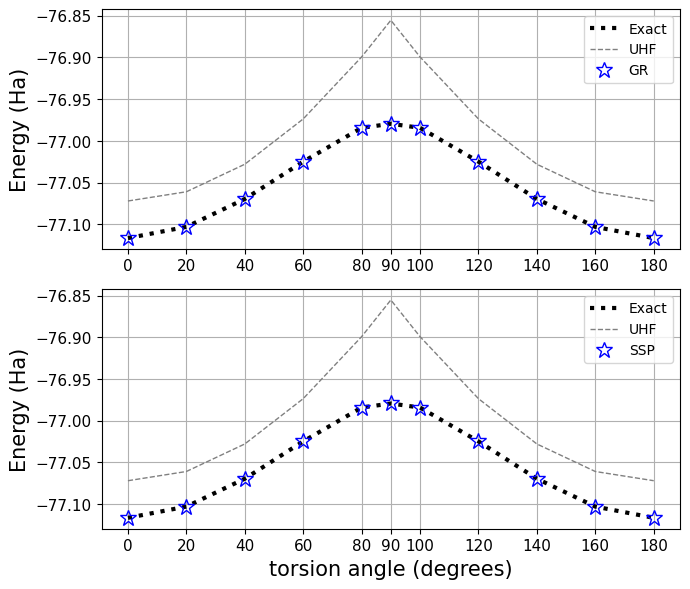

In [5]:
import matplotlib.pyplot as plt
from matplotlib import ticker

plt.rcParams.update({'font.size': 10})
fig, axs = plt.subplots(2, 1, figsize=(7, 6))  # one for each n_det

angles_list = [0, 20, 40, 60, 80, 90, 100, 120, 140, 160, 180]

# energies from exact diagonalization of the Hamiltonian matrices in the computational basis
ed = [-77.11659290533572, -77.10311001998393, -77.06967385411103, -77.02493132508863, -76.9843357521212, -76.97948874021279, -76.98433575212128, -77.02493132508863, -77.06967385411106, -77.10311001998393, -77.11659290533561]

# energies from Hartree-Fock
uhf = [-77.07208779770471, -77.06102964714935, -77.02802801200275, -76.97369422783478, -76.89933468493975, -76.85534456853723, -76.89933468493976, -76.97369422783476, -77.02802801200275, -77.06102964714927, -77.07208779770457]

# energies obtained from InQuanto using the GR method
gr_energies = [-77.11659290533474, -77.10311001997955, -77.06967385194167, -77.02493132461348, -76.9843357521205, -76.97948873253813, -76.98433575212044, -77.02493132461353, -77.06967385194156, -77.10311001997968, -77.11659290533483]

# energies obtained from InQuanto using the SSP method
ssp_energies = [-77.11659290533406, -77.10311001998025, -77.06967385410651, -77.02493132508846, -76.98433575208276, -76.97948873253824, -76.98433575208283, -77.02493132508845, -77.06967385410657, -77.10311001998026, -77.11659290533393]

# GR

axs[0].plot(angles_list, ed, linewidth=3, color='black', linestyle='dotted', label=r'Exact')
axs[0].plot(angles_list, uhf, linewidth=1, color='grey', linestyle='dashed', label=r'UHF')
axs[0].plot(angles_list, gr_energies, linestyle='None', color='blue', marker='*', markersize=12, markerfacecolor='None', label=r'GR')
# axs[0].set_xlabel(r'torsion angle (degrees)', size=15)
axs[0].set_xticks(angles_list)
axs[0].set_ylabel(r'Energy (Ha)', size=15)
axs[0].tick_params(labelsize=11)
axs[0].grid()
axs[0].legend()


# SSP

axs[1].plot(angles_list, ed, linewidth=3, color='black', linestyle='dotted', label=r'Exact')
axs[1].plot(angles_list, uhf, linewidth=1, color='grey', linestyle='dashed', label=r'UHF')
axs[1].plot(angles_list, ssp_energies, linestyle='None', color='blue', marker='*', markersize=12, markerfacecolor='None', label=r'SSP')
axs[1].set_xlabel(r'torsion angle (degrees)', size=15)
axs[1].set_xticks(angles_list)
axs[1].set_ylabel(r'Energy (Ha)', size=15)
axs[1].tick_params(labelsize=11)
axs[1].grid()
axs[1].legend()



fig.tight_layout()
plt.show()
# plt.savefig("c2h4_2in4_gr_ssp.pdf")

In [ ]:

# The following cells plot data obtained circuit simulations using Quantinuum's NexusBackend to model H-series trapped-ion quantum computers. 

# For more information, see https://www.quantinuum.com/products-solutions/quantinuum-systems/system-model-h1#

# To run calculations or compile circuits using the GR or SSP methods with Quantinuum's proprietary backends, 
# please contact the authors of https://arxiv.org/pdf/2508.05390


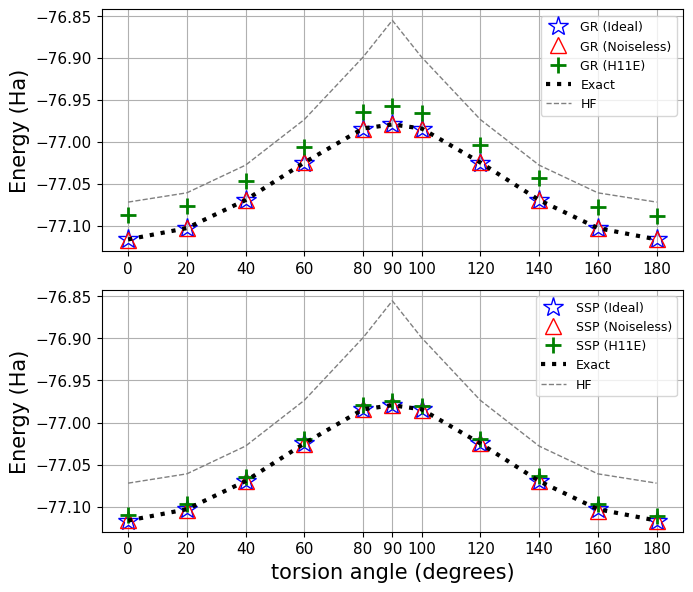

In [7]:
import matplotlib.pyplot as plt
from matplotlib import ticker

plt.rcParams.update({'font.size': 9})
fig, axs = plt.subplots(2, 1, figsize=(7, 6))

angles_list = [0, 20, 40, 60, 80, 90, 100, 120, 140, 160, 180]

spc = 10000

# energies from exact diagonalization of the Hamiltonian matrices in the computational basis
ed = [-77.11659290533572, -77.10311001998393, -77.06967385411103, -77.02493132508863, -76.9843357521212, -76.97948874021279, -76.98433575212128, -77.02493132508863, -77.06967385411106, -77.10311001998393, -77.11659290533561]

# energies from Hartree-Fock
uhf = [-77.07208779770471, -77.06102964714935, -77.02802801200275, -76.97369422783478, -76.89933468493975, -76.85534456853723, -76.89933468493976, -76.97369422783476, -77.02802801200275, -77.06102964714927, -77.07208779770457]

# energies obtained from InQuanto using the GR method
gr_energies = [-77.11659290533474, -77.10311001997955, -77.06967385194167, -77.02493132461348, -76.9843357521205, -76.97948873253813, -76.98433575212044, -77.02493132461353, -77.06967385194156, -77.10311001997968, -77.11659290533483]

# energies obtained from InQuanto using the SSP method
ssp_energies = [-77.11659290533406, -77.10311001998025, -77.06967385410651, -77.02493132508846, -76.98433575208276, -76.97948873253824, -76.98433575208283, -77.02493132508845, -77.06967385410657, -77.10311001998026, -77.11659290533393]


# GR

axs[0].plot(angles_list, gr_energies, linestyle='None', color='blue', marker='*', markersize=15, markerfacecolor='None', label=r'GR (Ideal)')

# energies obtained from noiseless circuit simulations, using GR method
h11e_energies_nbe_run = [-77.11756775005819, -77.10321040432748, -77.07004338042739, -77.02429770570272, -76.9846303828244, -76.9794886353878, -76.98500096083251, -77.02473063570838, -77.06986515888082, -77.10337468462367, -77.11602877602743]
axs[0].plot(angles_list, h11e_energies_nbe_run, linestyle='None', color='red', marker='^', markersize=12, markerfacecolor='None', label=r'GR (Noiseless)')

# energies obtained from circuit simulations with noise model corresponding to H1, using GR method
h11e_energies_nopart = [-77.08772181701595, -77.07684531357371, -77.0465777865187, -77.0057898145779, -76.96503448273951, -76.95751789771926, -76.96541977967318, -77.00455859668442, -77.04348397748262, -77.07760070610065, -77.08820757248509]
axs[0].plot(angles_list, h11e_energies_nopart, linestyle='None', color='green', marker='+', markersize=11, markerfacecolor='None', markeredgewidth=2, label=r'GR (H11E)')
axs[0].plot(angles_list, ed, linewidth=3, color='black', linestyle='dotted', label=r'Exact')
axs[0].plot(angles_list, uhf, linewidth=1, color='grey', linestyle='dashed', label=r'HF')

# axs[0].set_xlabel(r'torsion angle (degrees)', size=15)
axs[0].set_xticks(angles_list)
axs[0].set_ylabel(r'Energy (Ha)', size=15)
axs[0].tick_params(labelsize=11)
axs[0].grid()
axs[0].legend()


# SSP

axs[1].plot(angles_list, ssp_energies, linestyle='None', color='blue', marker='*', markersize=15, markerfacecolor='None', label=r'SSP (Ideal)')

h11e_energies_nbe_run = [-77.1161768387575, -77.10431595026664, -77.06911129135491, -77.02524801244266, -76.98417283069126, -76.97945370885186, -76.9846545188621, -77.024680677837, -77.06952029868059, -77.1046017203634, -77.11675296337519]
axs[1].plot(angles_list, h11e_energies_nbe_run, linestyle='None', color='red', marker='^', markersize=12, markerfacecolor='None', label=r'SSP (Noiseless)')

h11e_energies_nopart = [-77.11001414046014, -77.09648057571792, -77.06452480749591, -77.01925340500647, -76.97922941042054, -76.97445174433958, -76.980304590949, -77.0201816199208, -77.06392537636395, -77.0971273243269, -77.1113093892878]
axs[1].plot(angles_list, h11e_energies_nopart, linestyle='None', color='green', marker='+', markersize=12, markerfacecolor='None', markeredgewidth=2, label=r'SSP (H11E)')

axs[1].plot(angles_list, ed, linewidth=3, color='black', linestyle='dotted', label=r'Exact')
axs[1].plot(angles_list, uhf, linewidth=1, color='grey', linestyle='dashed', label=r'HF')
axs[1].set_xlabel(r'torsion angle (degrees)', size=15)
axs[1].set_xticks(angles_list)
axs[1].set_ylabel(r'Energy (Ha)', size=15)
axs[1].tick_params(labelsize=11)
axs[1].grid()
axs[1].legend()



fig.tight_layout()
plt.show()
# plt.savefig("c2h4_2in4_gr_ssp.pdf")